In [ ]:
from google.colab import files

# Abre o seletor de arquivos para você escolher o arquivo
uploaded = files.upload()

# Lista dos arquivos carregados
for file_name in uploaded.keys():
    print(f"Arquivo carregado: {file_name}")

Saving Infarto Base Publica.xlsx to Infarto Base Publica.xlsx
Arquivo carregado: Infarto Base Publica.xlsx


In [ ]:
import pandas as pd

df = pd.read_excel('Infarto Base Publica.xlsx')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separando as variáveis independentes e dependentes
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicando o SMOTE para balancear as classes (Target majoritariamente = 0)
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' para balancear as classes 50-50
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificando a distribuição das classes após o SMOTE - 50/50
print(f'Distribuição das classes no treino após SMOTE: {y_train_smote.value_counts()}')

Distribuição das classes no treino após SMOTE: DEATH_EVENT
0    150
1    150
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


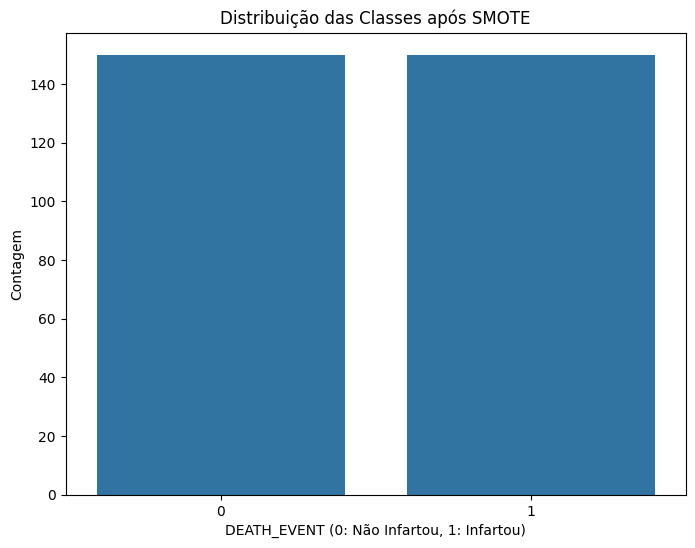

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizando a distribuição das classes no treino após o SMOTE
plt.figure(figsize=(8,6))
sns.countplot(x=y_train_smote)
plt.title('Distribuição das Classes após SMOTE')
plt.xlabel('DEATH_EVENT (0: Não Infartou, 1: Infartou)')
plt.ylabel('Contagem')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definindo o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)

# Parâmetros para testar no GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV para encontrar os melhores parâmetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Melhor configuração de parâmetros
print(f'Melhores parâmetros encontrados: {grid_search.best_params_}')

# Treinando o modelo com os melhores parâmetros
rf_best = grid_search.best_estimator_
rf_best.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores parâmetros encontrados: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(max_depth=20, random_state=42)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Obtendo as probabilidades para a classe 1
y_probs = rf_best.predict_proba(X_test)[:, 1]

# Testando vários thresholds e avaliando o f1-score
thresholds = np.arange(0.1, 1, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Encontrando o threshold que maximiza o f1-score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'O melhor threshold é: {best_threshold}')

# Calculando as previsões finais com o threshold ajustado
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Avaliando as métricas com o novo threshold
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))

O melhor threshold é: 0.25000000000000006
              precision    recall  f1-score   support

           0       0.94      0.62      0.75        53
           1       0.64      0.95      0.76        37

    accuracy                           0.76        90
   macro avg       0.79      0.78      0.76        90
weighted avg       0.82      0.76      0.75        90

[[33 20]
 [ 2 35]]
